In [116]:
# -------------------- Standard Library Imports --------------------
import argparse
import glob
import os
import sys
from multiprocessing import Pool, cpu_count
from random import sample
from subprocess import PIPE, Popen, STDOUT, call, run

# -------------------- Scientific Libraries ------------------------
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import pybedtools
import pysam
import scipy
import statsmodels.stats.multitest as smm
from Bio import SeqIO

# -------------------- Visualization Libraries ---------------------
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as clr
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from matplotlib_venn import venn2, venn2_circles

# -------------------- Matplotlib Configuration --------------------
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica Neue'

# -------------------- PyBedTools Temp Directory -------------------
pybedtools.helpers.set_tempdir('/fs/cbsuhy02/storage/jz855/tmp/') 


In [82]:
# Specify root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(project_root)


/local/storage/jz855/STARR_seq_code/Final_Code_Sharing


In [83]:
def calculate_interval_overlaps(d1, d2):
    """
    Perform BEDTools intersection between two BedTool objects, keeping the number of overlapping base pairs.

    Args:
        d1 (BedTool): First interval set.
        d2 (BedTool): Second interval set.

    Returns:
        pd.DataFrame: Intersected intervals with overlap length as the last column.
    """
    # Perform intersection with base pair overlap information
    intersect = d1.intersect(d2, wo=True)
    intersect = intersect.to_dataframe(disable_auto_names=True, header=None)

    # Sort and remove duplicate entries from d1
    if len(intersect) > 0:
        intersect = intersect.sort_values(intersect.columns[-1], ascending=False)
        intersect = intersect.drop_duplicates([0, 1, 2, 3])  # deduplicate based on d1's key columns

    return intersect


def filter_by_minimum_overlap_bp(comp_df, bp_cutoff):
    """
    Filter overlaps to retain only those with at least a minimum base-pair overlap.

    Args:
        comp_df (pd.DataFrame): Overlap dataframe from `calculate_interval_overlaps`.
        bp_cutoff (int): Minimum number of base pairs required to retain the overlap.

    Returns:
        pd.DataFrame: Filtered dataframe.
    """
    if len(comp_df) > 0:
        df = comp_df[comp_df[12] >= bp_cutoff].copy()  # column 12 = number of overlapping bp
    else:
        df = pd.DataFrame(columns=[x for x in range(0, 13)] + ['pct_overlap_1', 'pct_overlap_2'])

    return df


def filter_by_minimum_overlap_pct(comp_df, pct_cutoff, reciprocal=True):
    """
    Filter overlaps based on minimum percentage overlap (reciprocal or not).

    Args:
        comp_df (pd.DataFrame): Overlap dataframe with percent overlap calculated.
        pct_cutoff (float): Minimum percent overlap to consider.
        reciprocal (bool): If True, require both overlaps to pass cutoff; if False, either.

    Returns:
        pd.DataFrame: Filtered dataframe.
    """
    if len(comp_df) > 0:
        if reciprocal:
            df = comp_df[
                (comp_df['pct_overlap_1'] >= pct_cutoff) & 
                (comp_df['pct_overlap_2'] >= pct_cutoff)
            ].copy()
        else:
            df = comp_df[
                (comp_df['pct_overlap_1'] >= pct_cutoff) | 
                (comp_df['pct_overlap_2'] >= pct_cutoff)
            ].copy()
    else:
        df = pd.DataFrame(columns=[x for x in range(0, 13)] + ['pct_overlap_1', 'pct_overlap_2'])

    return df


In [84]:
def compute_pairwise_overlap_stats(peak_1, tested_2):
    """
    Compute pairwise overlap statistics between two sets of genomic intervals.

    Parameters:
    -----------
    peak_1 : pd.DataFrame
        BED-like DataFrame representing the first set of regions.
        Expected columns include: ['chr', 'start', 'end', 'name', ..., 'length'] at column 4.

    tested_2 : pd.DataFrame
        BED-like DataFrame representing the second set of regions to compare against.
        Expected columns include: ['chr', 'start', 'end', 'name', ..., 'length'] at column 10.

    Returns:
    --------
    pd.DataFrame
        Intersected regions with:
        - overlap length (column 12)
        - percentage overlap relative to each input set (pct_overlap_1, pct_overlap_2)
        - best hit per peak_1 and peak_2 (based on maximum overlap)
    """
    peak_1 = peak_1.sort_values(['chr', 'start'])
    tested_2 = tested_2.sort_values(['chr', 'start'])

    peak_1_bed = pybedtools.BedTool.from_dataframe(peak_1)
    tested_2_bed = pybedtools.BedTool.from_dataframe(tested_2)
    
    peak_1_vs_tested_2 = calculate_interval_overlaps(peak_1_bed, tested_2_bed)

    # Retain the best (largest) overlap per region from peak_1 and tested_2
    comp_df = peak_1_vs_tested_2.sort_values(12, ascending=False)
    comp_df = comp_df.drop_duplicates([0, 1, 2, 3])  # keep one match per region in peak_1
    comp_df = comp_df.sort_values(12, ascending=False)
    comp_df = comp_df.drop_duplicates([6, 7, 8, 9])  # keep one match per region in tested_2

    # Compute overlap percentages relative to both sets
    comp_df['pct_overlap_1'] = comp_df[12] / comp_df[4] * 100
    comp_df['pct_overlap_2'] = comp_df[12] / comp_df[10] * 100

    return comp_df


def record_overlap_count(comp_df, call_df, tested_df, dataset_1, dataset_2):
    """
    Record the number of overlapping 'active' regions and total comparisons into matrices.

    Parameters:
    -----------
    comp_df : pd.DataFrame
        Overlap results for a dataset pair (from compute_pairwise_overlap_stats).

    call_df : pd.DataFrame
        Matrix to record the number of overlapping regions labeled as 'active'.

    tested_df : pd.DataFrame
        Matrix to record total number of overlapping regions tested.

    dataset_1 : str
        Name of the dataset for rows.

    dataset_2 : str
        Name of the dataset for columns.
    """
    call_df.loc[dataset_1, dataset_2] = len(comp_df[comp_df[11] == 'active'])
    tested_df.loc[dataset_1, dataset_2] = len(comp_df)


def compute_pairwise_peak_overlap(peak_df_list, tested_df_list, dataset_list):
    """
    Compute pairwise overlaps between multiple datasets and summarize overlap statistics.

    For each pairwise combination of datasets, this function:
    - Computes 1 bp overlaps (any overlap)
    - Computes 50% reciprocal overlaps
    - Records both total overlaps and active overlaps

    Parameters:
    -----------
    peak_df_list : list of pd.DataFrame
        List of active region dataframes from each dataset.

    tested_df_list : list of pd.DataFrame
        List of tested region dataframes for overlap comparison.

    dataset_list : list of str
        Names corresponding to each dataset (should match order of lists above).

    Returns:
    --------
    list of list of pd.DataFrame
        A nested list containing:
        - First sublist: [comp_df_1bp, comp_df_50pct_reciprocal]
            Matrices of counts of 'active' overlaps for 1bp and 50% reciprocal thresholds.
        - Second sublist: [tested_df_1bp, tested_df_50pct_reciprocal]
            Matrices of total overlaps (regardless of call) for the same thresholds.
    """
    # Initialize matrices for storing overlap counts
    comp_df_1bp = pd.DataFrame(columns=dataset_list, index=dataset_list)
    comp_df_50pct_reciprocal = pd.DataFrame(columns=dataset_list, index=dataset_list)

    tested_df_1bp = pd.DataFrame(columns=dataset_list, index=dataset_list)
    tested_df_50pct_reciprocal = pd.DataFrame(columns=dataset_list, index=dataset_list)

    # Perform all pairwise comparisons
    for i in range(len(peak_df_list)):
        for j in range(len(tested_df_list)):
            peak_1 = peak_df_list[i]
            tested_2 = tested_df_list[j]
            dataset_1 = dataset_list[i]
            dataset_2 = dataset_list[j]

            if i == j:
                # Diagonal: self-comparison
                comp_df_1bp.loc[dataset_1, dataset_2] = len(peak_1)
                comp_df_50pct_reciprocal.loc[dataset_1, dataset_2] = len(peak_1)
                tested_df_1bp.loc[dataset_1, dataset_2] = len(peak_1)
                tested_df_50pct_reciprocal.loc[dataset_1, dataset_2] = len(peak_1)
            else:
                # Compare dataset_1 against dataset_2
                comp_df = compute_pairwise_overlap_stats(peak_1, tested_2)

                # Filter for minimum 1bp overlap
                overlap_1bp = filter_by_minimum_overlap_bp(comp_df, bp_cutoff=1)
                record_overlap_count(overlap_1bp, comp_df_1bp, tested_df_1bp, dataset_1, dataset_2)

                # Filter for reciprocal 50% overlap
                overlap_50pct_reciprocal = filter_by_minimum_overlap_pct(comp_df, pct_cutoff=50, reciprocal=True)
                record_overlap_count(overlap_50pct_reciprocal, comp_df_50pct_reciprocal, tested_df_50pct_reciprocal, dataset_1, dataset_2)

    return [[comp_df_1bp, comp_df_50pct_reciprocal],
            [tested_df_1bp, tested_df_50pct_reciprocal]]



In [85]:
def generate_jaccard_index_matrices(dataset_list, overlap_matrices):
    """
    Generate Jaccard index matrices for a list of datasets using overlap statistics.

    This function calculates the Jaccard index for each pair of datasets, based on:
    Jaccard(A, B) = |A ∩ B| / |A ∪ B| 
                  = max(overlap_AB, overlap_BA) / (total_A + total_B - max(overlap_AB, overlap_BA))

    Parameters:
    -----------
    dataset_list : list of str
        Names of all datasets to be compared.

    overlap_matrices : list of list of pd.DataFrame
        A nested list of pairwise overlap matrices, as returned by `compute_pairwise_peak_overlap()`.
        Format:
            [
                [active_overlap_1bp, active_overlap_50pct],         # number of 'active' overlaps
                [total_tested_1bp, total_tested_50pct]              # number of total overlaps
            ]

    Returns:
    --------
    list of pd.DataFrame
        A list of Jaccard index matrices (one per overlap method), with dataset names as row/col labels.
        Order corresponds to the order of overlap strategies (1bp overlap, 50% reciprocal overlap).
    """
    jaccard_index_matrices = []

    for comp_df, tested_df in zip(*overlap_matrices):
        
        jaccard_df = pd.DataFrame(columns=dataset_list, index=dataset_list)
        
        for i in range(len(dataset_list)):
            for j in range(len(dataset_list)):
                
                dataset_1 = dataset_list[i]
                dataset_2 = dataset_list[j]
                
                if i == j:
                    # Diagonal is not meaningful for Jaccard index
                    jaccard_df.loc[dataset_1, dataset_2] = 0
                else:
                    # Total number of tested regions per dataset
                    tested_1 = tested_df.loc[dataset_1, dataset_2]
                    tested_2 = tested_df.loc[dataset_2, dataset_1]
                    
                    # Number of overlapping active regions (use max of A->B and B->A)
                    active_1 = comp_df.loc[dataset_1, dataset_2]
                    active_2 = comp_df.loc[dataset_2, dataset_1]
                    num_active = np.max([active_1, active_2])

                    # Compute Jaccard index
                    jaccard_value = num_active / (tested_1 + tested_2 - num_active)
                    
                    # Fill in symmetric matrix
                    jaccard_df.loc[dataset_1, dataset_2] = jaccard_value
                    jaccard_df.loc[dataset_2, dataset_1] = jaccard_value
            
        jaccard_index_matrices.append(jaccard_df)

    return jaccard_index_matrices


In [86]:
def plot_overlap_percentage_heatmap(df_call, df_tested, title, output_file=''):
    """
    Plot a detailed heatmap showing overlap counts and percentages between datasets.

    For each pair of datasets, this function computes the percentage of overlapping elements
    (active/positive calls) out of total tested regions, and creates a heatmap with counts and percentages.

    Parameters:
    -----------
    df_call : pd.DataFrame
        A matrix of overlapping region counts (e.g., number of active overlaps).
        Rows and columns should be dataset names.

    df_tested : pd.DataFrame
        A matrix of total tested region counts (denominator for percentage calculations).
        Same shape and labels as `df_call`.

    title : str
        Title to display on the heatmap.

    output_file : str, optional
        Path to save the heatmap figure (PNG/PDF/etc). If empty, figure is not saved.

    Returns:
    --------
    None
    """

    # -----------------------------------
    # Step 1: Compute percent overlap matrix
    # -----------------------------------
    df_pct = pd.DataFrame(columns=df_call.columns.tolist(), index=df_call.columns.tolist())

    for i in range(len(df_call.columns)):
        for j in range(len(df_call.columns)):
            row = df_call.columns[i]
            col = df_call.columns[j]

            if df_tested.loc[row, col] > 0:
                df_pct.loc[row, col] = df_call.loc[row, col] / df_tested.loc[row, col] * 100
            else:
                df_pct.loc[row, col] = 0.00

    # -----------------------------------
    # Step 2: Create annotated heatmap labels
    # -----------------------------------
    annot = df_pct.applymap("{0:.2f}%".format)

    for row in annot.index:
        for col in annot.columns:
            if row == col:
                annot.loc[row, col] = "{:,}".format(int(df_call.loc[row, col])) + '\n' + annot.loc[row, col]
            else:
                annot.loc[row, col] = (
                    "{:,}".format(int(df_call.loc[row, col])) + '/' +
                    "{:,}".format(int(df_tested.loc[row, col])) + '\n' + annot.loc[row, col]
                )

    df_pct = df_pct.astype(float)

    # -----------------------------------
    # Step 3: Plot heatmap using seaborn
    # -----------------------------------
    fig = plt.figure(figsize=(12 / 5 * len(df_call), 12 / 5 * len(df_call)))
    sns.set_style(style='white')

    cmap = 'YlOrBr'
    ax = sns.heatmap(
        df_pct,
        cmap=cmap,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        vmin=0,
        vmax=100,
        annot=annot,
        annot_kws={"fontsize": 17},
        fmt='',
        cbar=True
    )

    # Configure tick positions and labels
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    tick_labels = df_pct.columns.tolist()
    ax.set_xticklabels(tick_labels, fontsize=17, rotation=90)
    plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels, rotation=0, fontsize=17, va="center")

    # Set title
    ax.set_title(title, fontsize=20)

    # Format colorbar ticks as percentages
    cbar = ax.collections[0].colorbar
    yticklabel = [t.get_text() for t in cbar.ax.get_yticklabels()]
    cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)
    cbar.ax.tick_params(labelsize=17)

    # -----------------------------------
    # Step 4: Save or display figure
    # -----------------------------------
    if output_file != '':
        plt.savefig(output_file, bbox_inches='tight', transparent=True, dpi=300)
        

In [87]:
def plot_jaccard_index_heatmap(df_jaccard, title, output_file=''):
    """
    Plot a heatmap of Jaccard indices to visualize pairwise similarity between datasets.

    This function plots a symmetric matrix where each cell represents the Jaccard index
    (i.e., intersection / union) of overlapping elements between two datasets.
    Only the lower triangle of the matrix is shown (to avoid redundancy).

    Parameters:
    -----------
    df_jaccard : pd.DataFrame
        A square DataFrame containing Jaccard index values between all pairs of datasets.
        Rows and columns should be dataset names.

    title : str
        Title of the plot.

    output_file : str, optional
        If provided, the heatmap is saved to this path.

    Returns:
    --------
    None
    """

    # Format each value as string with 2 decimal points
    annot = df_jaccard.applymap("{0:.2f}".format)

    # Ensure numeric type for plotting
    df_jaccard = df_jaccard.astype(float)

    # Mask upper triangle to keep only lower half (since matrix is symmetric)
    mask = np.triu(np.ones_like(df_jaccard, dtype=bool))

    # -------------------------------------------
    # Plot Setup
    # -------------------------------------------
    fig = plt.figure(figsize=(8 / 5 * len(df_jaccard), 8 / 5 * len(df_jaccard)))
    sns.set_style(style='white')

    cmap = 'YlOrBr'  # Yellow to Orange to Brown colormap

    # Draw heatmap
    ax = sns.heatmap(
        df_jaccard,
        cmap=cmap,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        vmin=0,
        vmax=1,
        annot=annot,
        annot_kws={"fontsize": 17},
        fmt='',
        cbar=True,
        mask=mask  # only show lower triangle
    )

    # Set axis tick positions
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # Format axis labels
    tick = df_jaccard.columns.tolist()
    ax.set_xticklabels(tick, fontsize=17, rotation=90)
    plt.yticks(np.arange(len(tick)) + 0.5, tick, rotation=0, fontsize=17, va="center")

    # Title
    ax.set_title(title, fontsize=20)

    # Format colorbar tick labels
    cbar = ax.collections[0].colorbar
    yticklabel = [t.get_text() for t in cbar.ax.get_yticklabels()]
    cbar.ax.set_yticklabels(['{:.2f}'.format(float(x)) for x in yticklabel], fontsize=17)
    cbar.ax.tick_params(labelsize=17)

    # Save to file if output path is provided
    if output_file != '':
        plt.savefig(output_file, bbox_inches='tight', transparent=True, dpi=300)
        

In [88]:
# Columns

columns = ['chr', 'start', 'end', 'name', 'logFC', 'strand', 'z_score', 'size', 'call', 
 'forward_raw', 'reverse_raw', 'total_raw', 'forward_signal', 'reverse_signal', 'total_signal', 
 'gro_chr', 'gro_start', 'gro_end', 'gro_type', 'gro_size', 'gro_overlap_bp', 'gro_overlap_pct_region', 'gro_overlap_pct_GROcap_element', 
 'ccre_chr', 'ccre_start', 'ccre_end', 'ccre_name', 'ccre_type', 'ccre_size', 'ccre_overlap_bp', 'ccre_overlap_pct_region', 'ccre_overlap_pct_ccre', 
 'promoter_400bp_tss', 'promoter_1kb_tss', 'promoter_4kb_tss', 
 'separate_GROcap_signal_levels', 'binary_transcription_class', 
 'divergent', 'unidirectional', 'bidirectional', 'not_overlap_GROcap_elements', 
 'CA_CTCF', 'CA_H3K4me3', 'CA_TF', 'dELS', 'pELS', 'Low_DNase', 'PLS', 'CA_only', 'not_overlap_cCRE', 
 'ELS', 'ELS_PLS']

print(len(columns))


52


In [93]:
# Load dataset, orientation-independent calls

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'LentiMPRA', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
lentimpra = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(lentimpra))
lentimpra.columns = columns

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'TilingMPRA', 'OL13_ENCSR394HXI', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
tilingmpra = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(tilingmpra))
tilingmpra.columns = columns


data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'ATAC_STARR_seq', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
atac_starr = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(atac_starr))
atac_starr.columns = columns

data_path = os.path.join(project_root, 'data', 'uniform_processed_data', 
                         'WHG_STARR_seq', 'annotated_results', 'annotated_tested_regions_both_orientations.bed.gz')
whg_starr = pd.read_csv(data_path, sep='\t', header=None, compression='gzip')
print(len(whg_starr))
whg_starr.columns = columns



109468
105
304921
1622613


In [122]:
print(atac_starr.groupby(['call', 'promoter_400bp_tss']).size())


call      promoter_400bp_tss
active    N                      10524
          Y                       1155
inactive  N                     290542
          Y                       2700
dtype: int64


In [121]:
whg_starr.groupby(['call', 'promoter_400bp_tss']).size()

call      46
active    N       24435
          Y        1070
inactive  N     1594096
          Y        3012

call      promoter_400bp_tss
active    N                       22077
          Y                        3428
inactive  N                     1594096
          Y                        3012
dtype: int64

In [124]:
whg_starr[whg_starr['call'] == 'active'].sort_values('name')

,chr,start,end,name,logFC,strand,z_score,size,call,forward_raw,reverse_raw,total_raw,forward_signal,reverse_signal,total_signal,gro_chr,gro_start,gro_end,gro_type,gro_size,gro_overlap_bp,gro_overlap_pct_region,gro_overlap_pct_GROcap_element,ccre_chr,ccre_start,ccre_end,ccre_name,ccre_type,ccre_size,ccre_overlap_bp,ccre_overlap_pct_region,ccre_overlap_pct_ccre,promoter_400bp_tss,promoter_1kb_tss,promoter_4kb_tss,separate_GROcap_signal_levels,binary_transcription_class,divergent,unidirectional,bidirectional,not_overlap_GROcap_elements,CA_CTCF,CA_H3K4me3,CA_TF,dELS,pELS,Low_DNase,PLS,CA_only,not_overlap_cCRE,ELS,ELS_PLS
53775,chr1,778420,779050,peak_both_1,1.7160523417401703,.,3.1333773540387195,630,active,218.0,2532.0,2750.0,0.346032,4.019048,4.365079,chr1,778552,778868,divergent,316,316,50.15873,100.000000,chr1,778570,778919,EH38E2776539,PLS,349,349,55.396825,100.000000,N,N,N,high_transcription,transcribed,moderate,.,.,.,.,.,.,.,.,.,moderate,.,.,.,moderate
725227,chr1,1017990,1018140,peak_both_10,1.5039170095634893,.,2.731123737086052,150,active,0.0,-0.0,0.0,0.000000,-0.000000,0.000000,.,-1,-1,.,-1,0,0.00000,-0.000000,chr1,1017840,1018136,EH38E2776817,Low-DNase,296,146,97.333333,49.324324,N,N,N,none_transcription,not_transcribed,.,.,.,not_overlap_GROcap_elements,.,.,.,.,.,low,.,.,.,.,.
858905,chr1,3192750,3192850,peak_both_100,1.24844847674323,.,2.246701173950967,100,active,0.0,-0.0,0.0,0.000000,-0.000000,0.000000,.,-1,-1,.,-1,0,0.00000,-0.000000,chr1,3192793,3193142,EH38E2779752,Low-DNase,349,57,57.000000,16.332378,N,N,N,none_transcription,not_transcribed,.,.,.,not_overlap_GROcap_elements,.,.,.,.,.,low,.,.,.,.,.
734792,chr1,87513340,87513480,peak_both_1000,1.191520235692417,.,2.1387531455180118,140,active,0.0,-0.0,0.0,0.000000,-0.000000,0.000000,.,-1,-1,.,-1,0,0.00000,-0.000000,chr1,87513315,87513657,EH38E2823009,Low-DNase,342,140,100.000000,40.935673,N,N,N,none_transcription,not_transcribed,.,.,.,not_overlap_GROcap_elements,.,.,.,.,.,low,.,.,.,.,.
1371446,chr17,78422760,78423040,peak_both_10000,1.5680710512871023,.,2.8527734173192463,280,active,0.0,-0.0,0.0,0.000000,-0.000000,0.000000,.,-1,-1,.,-1,0,0.00000,-0.000000,.,-1,-1,.,.,-1,0,0.000000,-0.000000,N,N,N,none_transcription,not_transcribed,.,.,.,not_overlap_GROcap_elements,.,.,.,.,.,.,.,.,not_overlap_cCRE,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506281,chr17,78263190,78263460,peak_both_9995,1.3713842214330791,.,2.4798134398184697,270,active,620.0,237.0,857.0,2.296296,0.877778,3.174074,chr17,78263170,78263576,divergent,406,270,100.00000,66.502463,chr17,78263227,78263542,EH38E3246512,dELS,315,233,86.296296,73.968254,N,N,N,high_transcription,transcribed,moderate,.,.,.,.,.,.,moderate,.,.,.,.,.,moderate,moderate
736184,chr17,78301080,78301220,peak_both_9996,1.225710489375794,.,2.203585123612132,140,active,23.0,14.0,37.0,0.164286,0.100000,0.264286,chr17,78301026,78301275,divergent,249,140,100.00000,56.224900,chr17,78300988,78301312,EH38E1888966,Low-DNase,324,140,100.000000,43.209877,N,N,N,high_transcription,transcribed,moderate,.,.,.,.,.,.,.,.,low,.,.,.,.,.
730921,chr17,78301370,78301530,peak_both_9997,2.345959095266181,.,4.3278142606532,160,active,9.0,11.0,20.0,0.056250,0.068750,0.125000,chr17,78301285,78301591,divergent,306,160,100.00000,52.287582,chr17,78301349,78301511,EH38E1888967,dELS,162,141,88.125000,87.037037,N,N,N,high_transcription,transcribed,moderate,.,.,.,.,.,.,high,.,.,.,.,.,high,high
1371447,chr17,78378970,78379090,peak_both_9998,1.168937019633635,.,2.095930574431632,120,active,6.0,2.0,8.0,0.050000,0.016667,0.066667,.,-1,-1,.,-1,0,0.00000,-0.000000,.,-1,-1,.,.,-1,0,0.000000,-0.000000,N,Y,Y,medium_transcription,transcribed,.,.,.,not_overlap_GROcap_elements,.,.,.,.,.,.,.,.,not_overlap_cCRE,.,.


In [94]:
# check

print(lentimpra.groupby(['call']).size())

print(tilingmpra.groupby(['call']).size())

print(atac_starr.groupby(['call']).size())

print(whg_starr.groupby(['call']).size())



call
active      16601
inactive    92867
dtype: int64
call
active      57
inactive    48
dtype: int64
call
active       11679
inactive    293242
dtype: int64
call
active        25505
inactive    1597108
dtype: int64


In [95]:
# subset peaks

lentimpra_peak = lentimpra[lentimpra['call'] == 'active']
print(len(lentimpra_peak))

tilingmpra_peak = tilingmpra[tilingmpra['call'] == 'active']
print(len(tilingmpra_peak))

atac_starr_peak = atac_starr[atac_starr['call'] == 'active']
print(len(atac_starr_peak))

whg_starr_peak = whg_starr[whg_starr['call'] == 'active']
print(len(whg_starr_peak))


16601
57
11679
25505


<ipython-input-86-3da364607415>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)
<ipython-input-86-3da364607415>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)
<ipython-input-87-4f93e9a38d50>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.2f}'.format(float(x)) for x in yticklabel], fontsize=17)
<ipython-input-87-4f93e9a38d50>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.2f}'.format(float(x)) for x in yticklabel], fontsize=17)


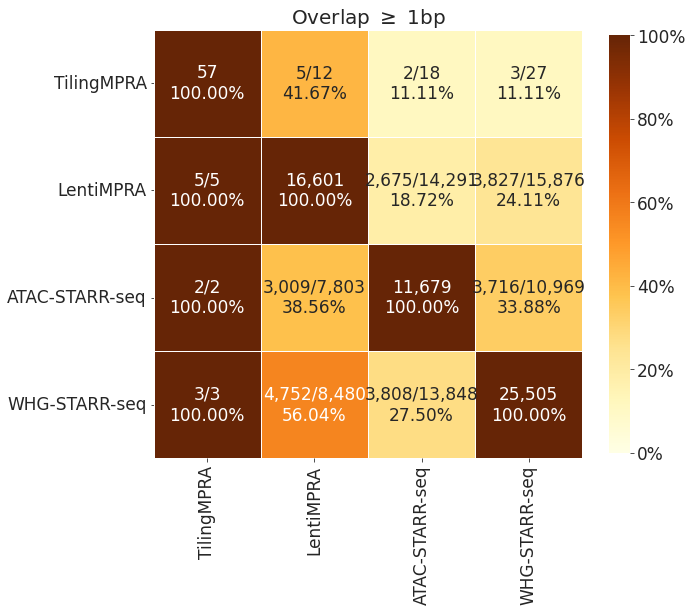

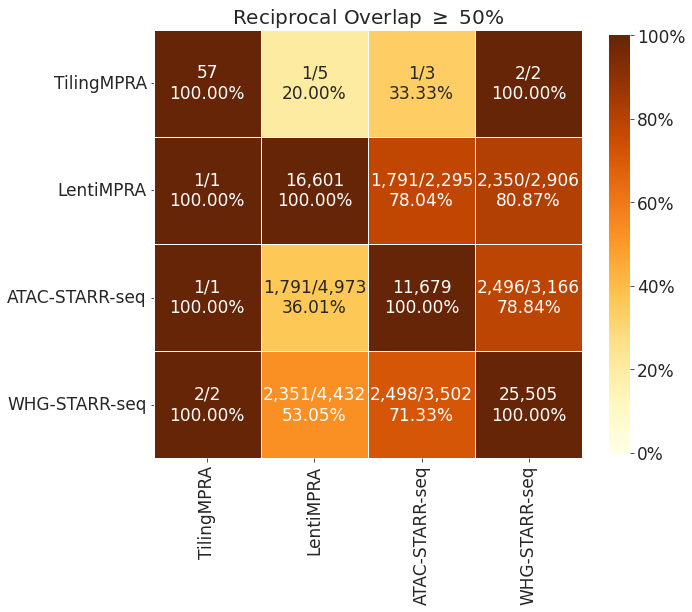

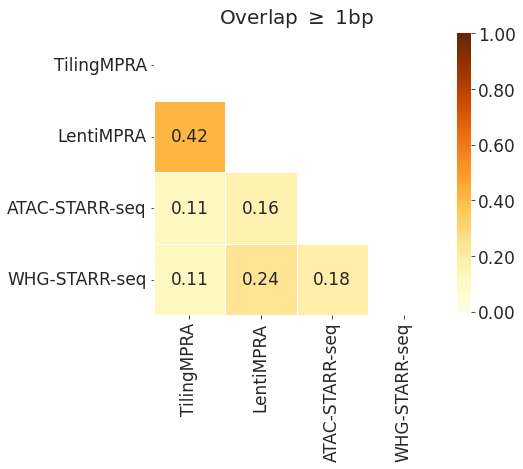

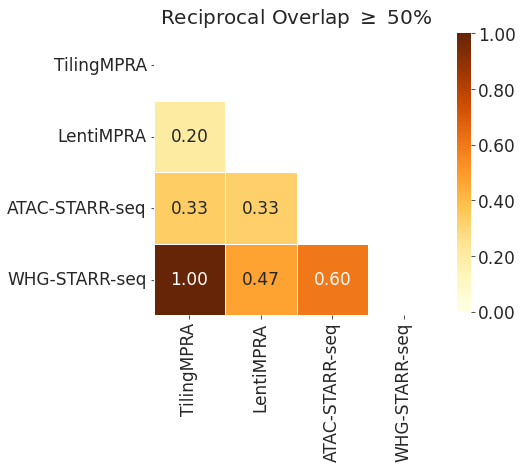

In [96]:
# -------------------------------------------
# Set plot title strings for overlap metrics
# -------------------------------------------
overlap_1bp_title_prefix = 'Overlap ' + u'$\geq$ ' + '1bp'
reciprocal_50pct_title_prefix = 'Reciprocal Overlap ' + u'$\geq$ ' + '50%'

# -------------------------------------------
# Prepare peak DataFrames for each dataset
# -------------------------------------------
peak_df_list = [
    tilingmpra_peak[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
    lentimpra_peak[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
    atac_starr_peak[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
    whg_starr_peak[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end'])
]

tested_df_list = [
    tilingmpra[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
    lentimpra[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
    atac_starr[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
    whg_starr[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end'])
]

dataset_list = ['TilingMPRA', 'LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq']

# -------------------------------------------
# Compute pairwise peak overlaps:
# [0] = 1bp overlap
# [1] = 50% reciprocal overlap
# -------------------------------------------
overlap_summary_matrices = compute_pairwise_peak_overlap(peak_df_list, tested_df_list, dataset_list)

# -------------------------------------------
# Compute Jaccard index matrices based on overlaps
# -------------------------------------------
jaccard_index_matrices = generate_jaccard_index_matrices(dataset_list, overlap_summary_matrices)

# -------------------------------------------
# Plot heatmaps (display only, no saving)
# -------------------------------------------

# 1bp overlap: counts + %
plot_overlap_percentage_heatmap(overlap_summary_matrices[0][0], overlap_summary_matrices[1][0], overlap_1bp_title_prefix)

# 50% reciprocal overlap: counts + %
plot_overlap_percentage_heatmap(overlap_summary_matrices[0][1], overlap_summary_matrices[1][1], reciprocal_50pct_title_prefix)

# 1bp overlap Jaccard index
plot_jaccard_index_heatmap(jaccard_index_matrices[0], overlap_1bp_title_prefix)

# 50% reciprocal overlap Jaccard index
plot_jaccard_index_heatmap(jaccard_index_matrices[1], reciprocal_50pct_title_prefix)



In [108]:
# Columns

columns = ['chr', 'start', 'end', 'name', 'logFC', 'strand', 'z_score', 'size', 'call', 
 'forward_raw', 'reverse_raw', 'total_raw', 'forward_signal', 'reverse_signal', 'total_signal', 
 'gro_chr', 'gro_start', 'gro_end', 'gro_type', 'gro_size', 'gro_overlap_bp', 'gro_overlap_pct_region', 'gro_overlap_pct_GROcap_element', 
 'ccre_chr', 'ccre_start', 'ccre_end', 'ccre_name', 'ccre_type', 'ccre_size', 'ccre_overlap_bp', 'ccre_overlap_pct_region', 'ccre_overlap_pct_ccre', 
 'promoter_400bp_tss', 'promoter_1kb_tss', 'promoter_4kb_tss', 
 'separate_GROcap_signal_levels', 'binary_transcription_class', 
 'divergent', 'unidirectional', 'bidirectional', 'not_overlap_GROcap_elements', 
 'CA_CTCF', 'CA_H3K4me3', 'CA_TF', 'dELS', 'pELS', 'Low_DNase', 'PLS', 'CA_only', 'not_overlap_cCRE', 
 'ELS', 'ELS_PLS']

print(len(columns))


52


In [109]:
# ----------------------------------------------------
# Separate distal vs proximal regions based on 1kb TSS proximity
# ----------------------------------------------------

# For lentiMPRA:
# Proximal = overlapping promoter ±1kb region (promoter_1kb_tss == 'Y')
# Distal = not overlapping (promoter_1kb_tss == 'N')

# Filter distal regions
distal_lentimpra = lentimpra[lentimpra['promoter_1kb_tss'] == 'N']
print(f"Distal lentiMPRA regions: {len(distal_lentimpra)}")

# Filter proximal regions
proximal_lentimpra = lentimpra[lentimpra['promoter_1kb_tss'] == 'Y']
print(f"Proximal lentiMPRA regions: {len(proximal_lentimpra)}")


# For ATAC-STARR-seq
distal_atac_starr = atac_starr[atac_starr['promoter_1kb_tss'] == 'N']
print(f"Distal ATAC-STARR-seq regions: {len(distal_atac_starr)}")

proximal_atac_starr = atac_starr[atac_starr['promoter_1kb_tss'] == 'Y']
print(f"Proximal ATAC-STARR-seq regions: {len(proximal_atac_starr)}")


# For WHG-STARR-seq
distal_whg_starr = whg_starr[whg_starr['promoter_1kb_tss'] == 'N']
print(f"Distal WHG-STARR-seq regions: {len(distal_whg_starr)}")

proximal_whg_starr = whg_starr[whg_starr['promoter_1kb_tss'] == 'Y']
print(f"Proximal WHG-STARR-seq regions: {len(proximal_whg_starr)}")



Distal lentiMPRA regions: 92697
Proximal lentiMPRA regions: 16771
Distal ATAC-STARR-seq regions: 289938
Proximal ATAC-STARR-seq regions: 14983
Distal WHG-STARR-seq regions: 1600429
Proximal WHG-STARR-seq regions: 22184


In [110]:
# ----------------------------------------------------
# Subset active peaks from proximal and distal regions
# ----------------------------------------------------

# lentiMPRA
# Get active peaks among distal regions
distal_lentimpra_peak = distal_lentimpra[distal_lentimpra['call'] == 'active']
print(f"Active distal lentiMPRA peaks: {len(distal_lentimpra_peak)}")

# Get active peaks among proximal regions
proximal_lentimpra_peak = proximal_lentimpra[proximal_lentimpra['call'] == 'active']
print(f"Active proximal lentiMPRA peaks: {len(proximal_lentimpra_peak)}")


# ATAC-STARR-seq
# Get active peaks among distal regions
distal_atac_starr_peak = distal_atac_starr[distal_atac_starr['call'] == 'active']
print(f"Active distal ATAC-STARR-seq peaks: {len(distal_atac_starr_peak)}")

# Get active peaks among proximal regions
proximal_atac_starr_peak = proximal_atac_starr[proximal_atac_starr['call'] == 'active']
print(f"Active proximal ATAC-STARR-seq peaks: {len(proximal_atac_starr_peak)}")


# WHG-STARR-seq
# Get active peaks among distal regions
distal_whg_starr_peak = distal_whg_starr[distal_whg_starr['call'] == 'active']
print(f"Active distal WHG-STARR-seq peaks: {len(distal_whg_starr_peak)}")

# Get active peaks among proximal regions
proximal_whg_starr_peak = proximal_whg_starr[proximal_whg_starr['call'] == 'active']
print(f"Active proximal WHG-STARR-seq peaks: {len(proximal_whg_starr_peak)}")



Active distal lentiMPRA peaks: 10915
Active proximal lentiMPRA peaks: 5686
Active distal ATAC-STARR-seq peaks: 9460
Active proximal ATAC-STARR-seq peaks: 2219
Active distal WHG-STARR-seq peaks: 18391
Active proximal WHG-STARR-seq peaks: 7114


<ipython-input-86-3da364607415>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)
<ipython-input-86-3da364607415>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)
<ipython-input-87-4f93e9a38d50>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.2f}'.format(float(x)) for x in yticklabel], fontsize=17)
<ipython-input-87-4f93e9a38d50>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.2f}'.format(float(x)) for x in yticklabel], fontsize=17)


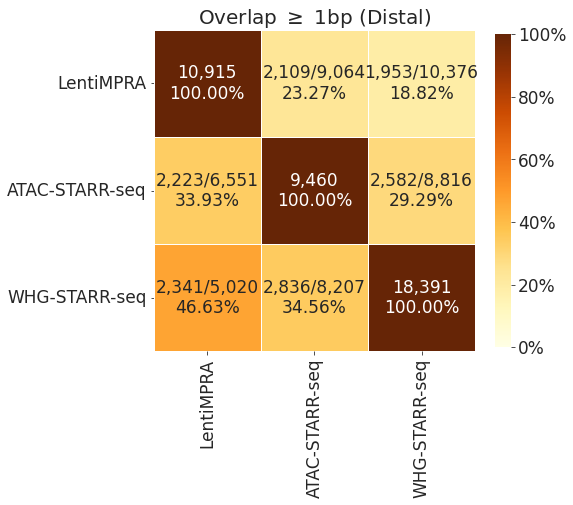

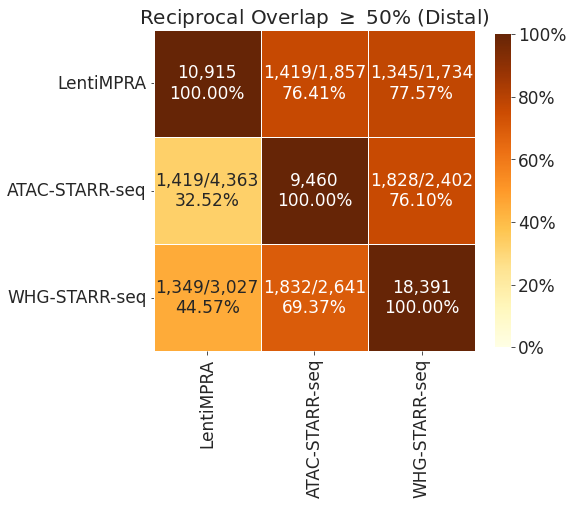

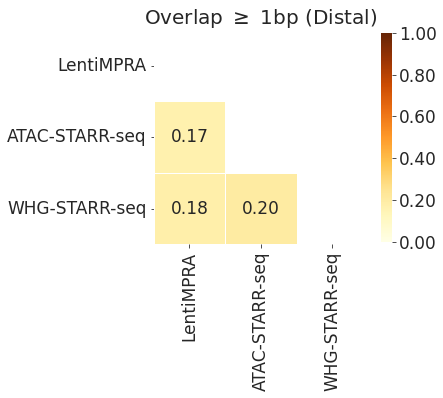

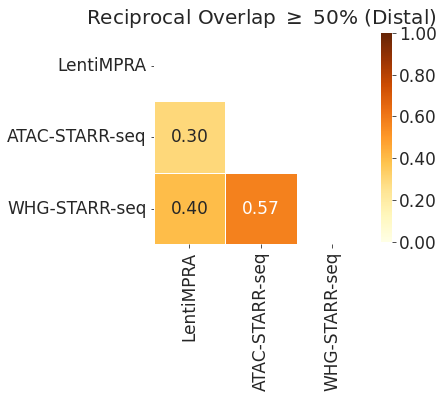

In [106]:
# ------------------------------------------------------------
# Analyze distal enhancer activity overlaps across datasets
# ------------------------------------------------------------

# -------------------------------------------
# Set plot title strings for overlap metrics
# -------------------------------------------
overlap_1bp_title_prefix = 'Overlap ' + u'$\geq$ ' + '1bp' + ' (Distal)'                 # For any 1bp overlap
reciprocal_50pct_title_prefix = 'Reciprocal Overlap ' + u'$\geq$ ' + '50%' + ' (Distal)' # For 50% reciprocal overlap

# -------------------------------------------
# Prepare input DataFrames for peak and tested regions
# One list for active peaks only, one for all tested regions (distal only)
# -------------------------------------------

# Peak regions (active only, no duplicates)
peak_df_list = [
    distal_lentimpra_peak[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
    distal_atac_starr_peak[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
    distal_whg_starr_peak[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end'])
]

# All tested distal regions (regardless of activity, no duplicates)
tested_df_list = [
    distal_lentimpra[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
    distal_atac_starr[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
    distal_whg_starr[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end'])
]

# Dataset labels for display and matrix indexing
dataset_list = ['LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq']

# -------------------------------------------
# Compute pairwise peak overlaps across datasets:
# Result is a list:
#   [0] = overlap counts matrix (1bp and 50% reciprocal)
#   [1] = total tested region matrix (1bp and 50% reciprocal)
# -------------------------------------------
overlap_summary_matrices = compute_pairwise_peak_overlap(peak_df_list, tested_df_list, dataset_list)

# -------------------------------------------
# Compute Jaccard index matrices for each overlap type
# One matrix per type of overlap (1bp, 50% reciprocal)
# -------------------------------------------
jaccard_index_matrices = generate_jaccard_index_matrices(dataset_list, overlap_summary_matrices)

# -------------------------------------------
# Plot overlap matrices with percentage annotations
# And display Jaccard index heatmaps
# -------------------------------------------

# Heatmap: 1bp overlap (count + % of tested)
plot_overlap_percentage_heatmap(
    overlap_summary_matrices[0][0],  # active overlap counts
    overlap_summary_matrices[1][0],  # total tested regions
    overlap_1bp_title_prefix
)

# Heatmap: 50% reciprocal overlap (count + % of tested)
plot_overlap_percentage_heatmap(
    overlap_summary_matrices[0][1], 
    overlap_summary_matrices[1][1], 
    reciprocal_50pct_title_prefix
)

# Jaccard heatmap: 1bp overlaps
plot_jaccard_index_heatmap(jaccard_index_matrices[0], overlap_1bp_title_prefix)

# Jaccard heatmap: 50% reciprocal overlaps
plot_jaccard_index_heatmap(jaccard_index_matrices[1], reciprocal_50pct_title_prefix)


<ipython-input-86-3da364607415>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)
<ipython-input-86-3da364607415>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}%'.format(float(x)) for x in yticklabel], fontsize=17)
<ipython-input-87-4f93e9a38d50>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.2f}'.format(float(x)) for x in yticklabel], fontsize=17)
<ipython-input-87-4f93e9a38d50>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.2f}'.format(float(x)) for x in yticklabel], fontsize=17)


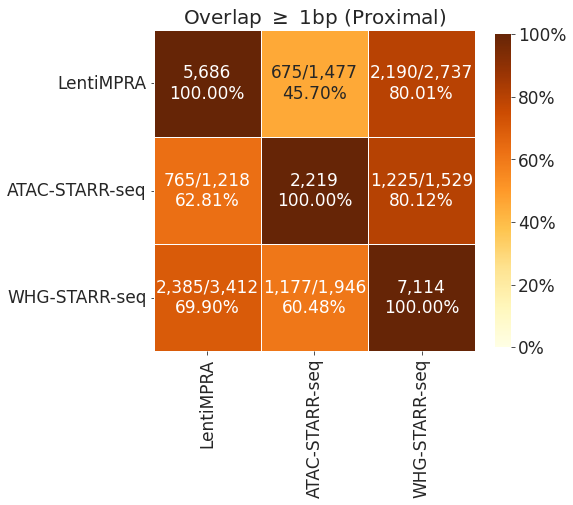

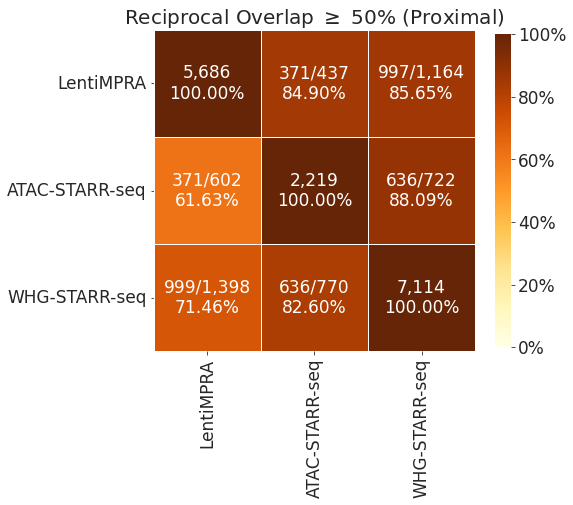

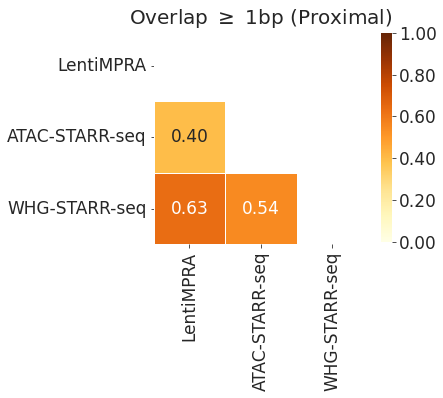

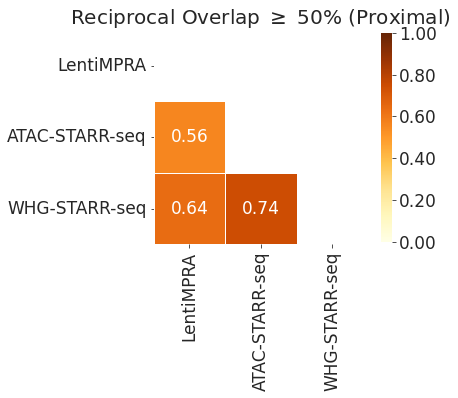

In [107]:
# ------------------------------------------------------------
# Analyze proximal enhancer activity overlaps across datasets 
# ------------------------------------------------------------

# -------------------------------------------
# Set plot title strings for overlap metrics
# -------------------------------------------
overlap_1bp_title_prefix = 'Overlap ' + u'$\geq$ ' + '1bp' + ' (Proximal)'                 # For any 1bp overlap
reciprocal_50pct_title_prefix = 'Reciprocal Overlap ' + u'$\geq$ ' + '50%' + ' (Proximal)' # For 50% reciprocal overlap

# -------------------------------------------
# Prepare input DataFrames for peak and tested regions
# One list for active peaks only, one for all tested regions (distal only)
# -------------------------------------------

# Peak regions (active only, no duplicates)
peak_df_list = [
    proximal_lentimpra_peak[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
    proximal_atac_starr_peak[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
    proximal_whg_starr_peak[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end'])
]

# All tested distal regions (regardless of activity, no duplicates)
tested_df_list = [
    proximal_lentimpra[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
    proximal_atac_starr[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end']),
    proximal_whg_starr[['chr', 'start', 'end', 'name', 'size', 'call']].drop_duplicates(['chr', 'start', 'end'])
]

# Dataset labels for display and matrix indexing
dataset_list = ['LentiMPRA', 'ATAC-STARR-seq', 'WHG-STARR-seq']

# -------------------------------------------
# Compute pairwise peak overlaps across datasets:
# Result is a list:
#   [0] = overlap counts matrix (1bp and 50% reciprocal)
#   [1] = total tested region matrix (1bp and 50% reciprocal)
# -------------------------------------------
overlap_summary_matrices = compute_pairwise_peak_overlap(peak_df_list, tested_df_list, dataset_list)

# -------------------------------------------
# Compute Jaccard index matrices for each overlap type
# One matrix per type of overlap (1bp, 50% reciprocal)
# -------------------------------------------
jaccard_index_matrices = generate_jaccard_index_matrices(dataset_list, overlap_summary_matrices)

# -------------------------------------------
# Plot overlap matrices with percentage annotations
# And display Jaccard index heatmaps
# -------------------------------------------

# Heatmap: 1bp overlap (count + % of tested)
plot_overlap_percentage_heatmap(
    overlap_summary_matrices[0][0],  # active overlap counts
    overlap_summary_matrices[1][0],  # total tested regions
    overlap_1bp_title_prefix
)

# Heatmap: 50% reciprocal overlap (count + % of tested)
plot_overlap_percentage_heatmap(
    overlap_summary_matrices[0][1], 
    overlap_summary_matrices[1][1], 
    reciprocal_50pct_title_prefix
)

# Jaccard heatmap: 1bp overlaps
plot_jaccard_index_heatmap(jaccard_index_matrices[0], overlap_1bp_title_prefix)

# Jaccard heatmap: 50% reciprocal overlaps
plot_jaccard_index_heatmap(jaccard_index_matrices[1], reciprocal_50pct_title_prefix)

